# Cross Encoder Reranker
* Notebook by Adam Lang
* Date: 3/26/2025

# Overview
* In this notebook we will implement a cross encoder reranker from SentenceTransformers for 2 stage retrieval.

# Advanced RAG Techniques
* We will use these advanced retrieval techniques:
1. Query expansion
2. Cross Encoder with Rerank
3. LongContextReorder

# Install Dependencies

In [2]:
%%capture
!pip install langchain-openai langchain langchain-chroma tiktoken umap-learn sentence-transformers matplotlib

In [3]:
%%capture
!pip install langchain_community

In [4]:
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_chroma import Chroma
from dotenv import load_dotenv, find_dotenv
import os

# Get Datasets
* I am going to load 2 datasets using Pathlib

In [5]:
import requests
from pathlib import Path

## download if not exists already
if Path("data1.txt").is_file():
  print("data1.txt already exists, skipping download....")
elif Path("data2.txt").is_file():
  print("data2.txt already exists skipping download...")
else:
  print("Downloading 2 text files")
  ## 1. get raw github files
  request_1 = requests.get("https://raw.githubusercontent.com/Coding-Crashkurse/Applied-Advanced-RAG/refs/heads/main/data1.txt")
  request_2 = requests.get("https://raw.githubusercontent.com/Coding-Crashkurse/Applied-Advanced-RAG/refs/heads/main/data2.txt")
  ## 2. Open files
  with open("data1.txt", "wb") as f:
    f.write(request_1.content)
  with open("data2.txt", "wb") as f:
    f.write(request_2.content)

data1.txt already exists, skipping download....


# Directory Loader
* Load docs into directory loader.

In [6]:
## set up loader
loader = DirectoryLoader('./', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

In [7]:
## view docs
docs

[Document(metadata={'source': 'data2.txt'}, page_content="La Bella Vita offers a gastronomic journey through the rich landscapes of Italian cuisine, encapsulating the essence of Italy's culinary tradition. The restaurant's ambiance, reminiscent of a rustic Italian villa, sets the stage for an authentic dining experience.\nThe chefs at La Bella Vita are masters of their craft, bringing generations of Italian cooking expertise to the table. The menu features a variety of regional specialties, showcasing the diversity of Italian cuisine. From the northern delicacies like risotto and polenta to the southern favorites like Neapolitan pizza and Sicilian seafood, each dish tells a story of its regional origin.\nThe pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and gnocchi, each prepared with homemade pasta and cooked to perfection. The sauces, ranging from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the authe

In [8]:
## len of docs
print(f"Length of docs: {len(docs)}")

Length of docs: 2


# Text Splitting/Chunking
* Now we will split and chunk the text before creating vector embeddings and storing then in a ChromaDB vector database.

In [9]:
## init text splitter -- using default RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len,
)
chunked_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in chunked_docs]

# Setup OpenAI Environments

In [10]:
import os
from getpass import getpass

OPENAI_API_KEY = getpass("Enter your OPEN AI API KEY: ")

Enter your OPEN AI API KEY: ··········


In [11]:
## set open ai env variable
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

# Embeddings
* Now we can create embeddings.
* We can use the OpenAI Embeddings.

In [12]:
## 1. init embedding model
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

## 2. create embeddings of documents
vectors = embeddings.embed_documents(doc_strings)

# Chroma DB Vector database setup
* Note about Chroma DB distance function: need to set distance function to cosine or uses default euclidean!

In [54]:
# create vector DB of docs and embeddings
chroma_db = Chroma.from_documents(documents=chunked_docs,
                                  #collection_name='cross_encoder_data',
                                  embedding=embeddings)
                                  # need to set distance function to cosine or uses default euclidean!
                                  #collection_metadata={'hnsw:space': 'cosine'},
                                  #persist_directory="./cross_encoder_db")


Code below is to run if you have already created your embeddings --> indexed and inserted them in to ChromaDB.

In [14]:
# ## connect and load vector DB
# chroma_db = Chroma(persist_directory="./cross_encoder_data",
#                    collection_name='cross_encoder_db',
#                    embedding_function=embeddings)


# Retriever Setup

In [55]:
## similarity retriever
retriever = chroma_db.as_retriever(search_kwargs={'k': 6})

In [56]:
## lets see how many docs are in the chroma db
print(f"Number of documents in Chroma DB: {chroma_db._collection.count()}")


Number of documents in Chroma DB: 63


## Test Chroma DB collection

In [57]:
#If the database is populated, let's test the retriever with a simple query:
test_query = "loans"  # or any term you expect to be in your documents
test_docs = retriever.get_relevant_documents(test_query)
print(f"Number of documents retrieved for test query '{test_query}': {len(test_docs)}")
if test_docs:
    print(f"First document snippet: {test_docs[0].page_content[:100]}...")
else:
    print("No documents retrieved. This might indicate an issue with the retriever or the database.")

Number of documents retrieved for test query 'loans': 6
First document snippet: growth and expansion. These loans are tailored to each business's unique needs, whether it's for...


# Visualize/Evaluate Embeddings
* We can use UMAP for dimensionality reduction to do this.

In [1]:
!pip install --upgrade umap-learn

In [58]:
import umap
import numpy as np
from tqdm import tqdm

## setup umap model -- random state to prevent variance
umap_transformer = umap.UMAP(random_state=42,
                       transform_seed=42).fit(vectors)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## UMAP 2-D embeddings

In [59]:
## function to create 2-D embeddings
def umap_embed(vectors, umap_transformer):
  """
  Function to create umap 2-D embeddings.
  """
  umap_embeddings = np.array([umap_transformer.transform([vector])[0] for vector in tqdm(vectors)])
  return umap_embeddings

In [60]:
## create global embeddings
global_embeddings = umap_embed(vectors, umap_transformer)
global_embeddings

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  wa

array([[  2.9818661 ,   6.75496   ],
       [  2.5337164 ,   5.224897  ],
       [  2.3525417 ,   5.153891  ],
       [  2.9306765 ,   5.6290755 ],
       [  0.06753659,   7.4727817 ],
       [ -0.03394433,   7.566425  ],
       [  0.06731142,   7.076279  ],
       [ -0.2131629 ,   6.856114  ],
       [  1.9049013 ,   7.932933  ],
       [  1.7974608 ,   8.072239  ],
       [  3.2798593 ,   5.8210974 ],
       [  0.06941492,   6.420033  ],
       [  1.5960119 ,   8.219105  ],
       [  0.2277978 ,   8.063303  ],
       [  2.381305  ,   7.6519623 ],
       [  0.03775964,   6.1825643 ],
       [  0.5790033 ,   8.381939  ],
       [  0.19016473,   7.977628  ],
       [  2.9608233 ,   5.49673   ],
       [  0.1810786 ,   5.8743925 ],
       [  3.0440426 ,   7.1045756 ],
       [  0.36769432,   5.568306  ],
       [  2.7850888 ,   6.9820046 ],
       [  1.9984472 ,   7.6789217 ],
       [  2.4743867 ,   7.6599364 ],
       [  3.001254  ,   5.451304  ],
       [  1.276011  ,   4.254037  ],
 

(-10.921064603328706, 3.9560937762260435, 4.047641801834106, 8.588334035873412)

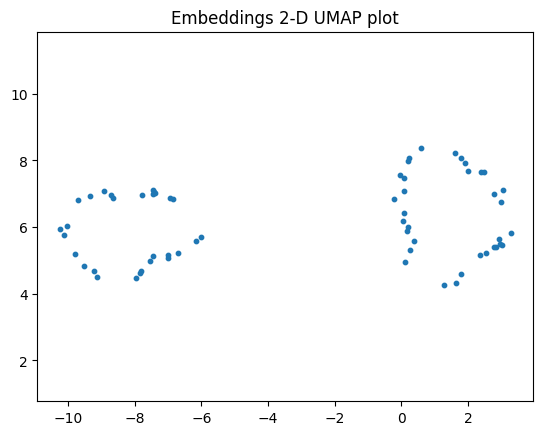

In [62]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Embeddings 2-D UMAP plot")
plt.axis()

Summary
* The purpose of this dimensionality reduction was to see the similarites vs. differences in our embeddings.
* We have 2 different datasets that we embedded: Bank text, Restaurant text.
* And as we can see there are 2 unique clusters in very different vector spaces.

In [63]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    plt.figure()
    plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()


In [69]:
def calc_global_embeddings(query, embeddings, retriever, umap_transformer, embed_function, global_embeddings):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    vectors_content_vectors = embeddings.embed_documents(page_contents)

    query_embeddings = embed_function([q_embedding], umap_transformer)
    retrieved_embeddings = embed_function(vectors_content_vectors, umap_transformer)

    plt.figure()
    plt.scatter(global_embeddings[:, 0], global_embeddings[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis()
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

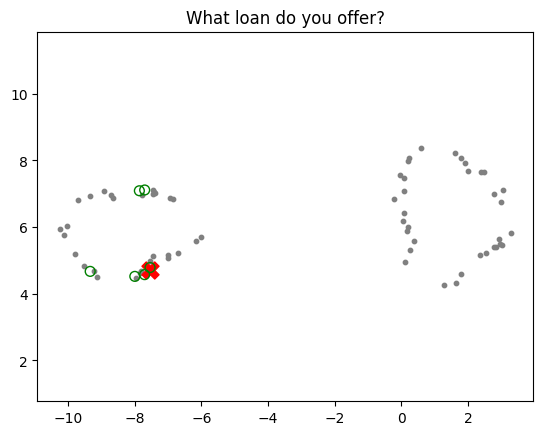

In [70]:
calc_global_embeddings("What loan do you offer?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

Summary
* We can see the green dots are the retrieved documents in relation to the red X for the bank related query and it was within the bank data cluster.

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

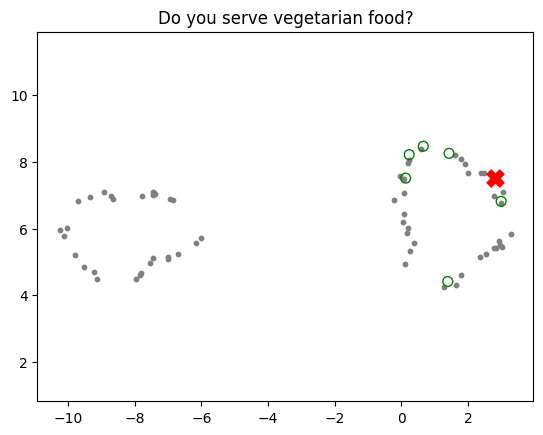

In [94]:
## Test a restaurant related query
calc_global_embeddings("Do you serve vegetarian food?", embeddings, retriever, umap_transformer, umap_embed, global_embeddings)

Summary
* We can see the query landed in the right cluster which is the restaurant text and we can see the Red dot did not hit an exact vector but it was close to a couple of retrieved documents.
* This is good to know if we want to improve our queries and embeddings in the future!
* Query Expansion and reranking are 2 methods to do this and we will show that next.

# Query Expansion

* Query expansion is a technique used to improve the accuracy of information retrieval systems by enhancing the original user query with additional, contextually relevant terms or phrases.
* The goal is to bridge the gap between how users express their intent and how the information is represented in the data repository.

## Why is Query Expansion even Necessary?
* [source](https://medium.com/@sahin.samia/query-expansion-in-enhancing-retrieval-augmented-generation-rag-d41153317383)
1. **Ambiguity**
  * Many queries can have multiple semantic and contextual meanings.
  * As an example, the word “bank” can refer to the place you get money from, a river bank, or a snow bank (pile of snow).

2. **Vocabulary Mismatch**
  * Users often use different words or phrases than those used in the documents.
  * For example, a query for “car maintenance” might miss results labeled as “vehicle servicing” or “auto repair.”

3. **Lack of Context**
  * Short or vague queries may not provide enough detail to retrieve the most relevant results, leading to poor precision and recall.

## How Query Expansion Works
* This refines the original query by incorporating additional terms that are:
  * **Synonyms**
    * Words with similar meanings, e.g., “house” expanded to “home.”
  * **Related Concepts**
    * Contextually linked phrases, e.g., “climate change” expanded to “global warming effects.”
  * **Contextual Terms**
    * Terms derived from the top retrieved results of an initial search.

In [95]:
from langchain_openai import ChatOpenAI

## setup llm parameters
llm = ChatOpenAI(
    temperature=0.9, ## change based on app requirements
    max_tokens=800,
    top_p=0.3,
    frequency_penalty=0,
    presence_penalty=0,
)

## Query Expansion setup
* Now we take initial query and pass to LLM for query expansion.
* We leverage Pydantic for type hints.

In [98]:
from langchain.chains import LLMChain
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
#from pydantic import BaseModel, Field #removed unused import

## initial restaurant query
query = "Do you serve vegetarian food?"

#removed unused class
# class LineList(BaseModel):
#     lines: list[str] = Field(description="Lines of text")


class LineListOutputParser(StrOutputParser):
    """Parse the output of an LLM call to a list of lines."""

    def parse(self, text: str) -> list[str]:
        lines = text.strip().split("\n")
        return {"lines": lines}  # <-- Return a dictionary for compatibility with LLMChain

    @property
    def _type(self) -> str:
        return "line_list"


output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant.
    Your task is to generate five unique versions of a given user question to retrieve relevant documents from a vector
    database.
    By generating multiple unique versions of a user question, your goal is to help
    the user overcome the limitations of the distance-based similarity search.
    Please use synonyms, related concepts, and contextually similar terms when expanding your queries.
    As an example: If a user mentions "waffles" consider expanding this to "breakfast foods" as it is semantically similar.
    Provide these alternative questions separated by newlines.
    Only provide the query, no numbering.
    Original question: {question}""",
)

## create chain
llm_chain = LLMChain(llm=llm, prompt=QUERY_PROMPT, output_parser=output_parser)
## get expanded queries
queries = llm_chain.invoke(query)

In [100]:
## view the expanded queries
queries = queries.get("text")
queries

{'lines': ['Do you offer plant-based options?',
  'Are there vegetarian dishes on the menu?',
  'Is there a selection of vegetarian meals available?',
  'Do you have any meatless options?',
  'Are there any dishes suitable for vegetarians?']}

In [101]:
## retrieve docs from vector db
docs = [retriever.get_relevant_documents(query) for query in queries]

In [102]:
## find only unique documents
unique_contents = set()
unique_docs = []
for sublist in docs:
    for doc in sublist:
        if doc.page_content not in unique_contents:
            unique_docs.append(doc)
            unique_contents.add(doc.page_content)
unique_contents = list(unique_contents)
unique_contents

["financial advisors are skilled in crafting investment strategies that align with clients' long-term",
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the',
 'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 "planning, and estate planning, ensuring clients' financial futures are secure.",
 'from well-known labels to hidden gems from small vineyards across Italy. The staff are',
 'possible, providing support and advice at every step.']

Summary
* Query expansion has its limitations as we can see.
* Lets see what adding a Cross Encoder with reranking can do.

# Cross Encoder with Reranking
* This is the cross encoder we will use from hugging face: `cross-encoder/ms-marco-MiniLM-L6-v2`
* Model card: https://huggingface.co/cross-encoder/ms-marco-MiniLM-L6-v2

In [103]:
from sentence_transformers import CrossEncoder

## load cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Create Document Pairs
* With a cross encoder the object is to pass each query-doc pair to the cross encoder model in the same vector space.

In [104]:
## create pairs
pairs = []
for doc in unique_contents:
  pairs.append([query, doc])

In [105]:
## generate sim scores
sim_scores = cross_encoder.predict(pairs)
sim_scores

array([-11.220272, -10.613697, -10.557279, -11.162832, -11.280336,
       -10.640901], dtype=float32)

## Sort pair docs and Rerank them

In [106]:
## Zip sim scores to unique documents
scored_docs = zip(sim_scores, unique_contents)
## Sort docs
sorted_docs = sorted(scored_docs, reverse=True)
sorted_docs

[(-10.557279,
  'The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and'),
 (-10.613697,
  'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the'),
 (-10.640901, 'possible, providing support and advice at every step.'),
 (-11.162832,
  "planning, and estate planning, ensuring clients' financial futures are secure."),
 (-11.220272,
  "financial advisors are skilled in crafting investment strategies that align with clients' long-term"),
 (-11.280336,
  'from well-known labels to hidden gems from small vineyards across Italy. The staff are')]

In [107]:
## rerank to get the 5 most similar documents
rerank_docs = [doc for _, doc in sorted_docs][0:5]
rerank_docs

['The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the',
 'possible, providing support and advice at every step.',
 "planning, and estate planning, ensuring clients' financial futures are secure.",
 "financial advisors are skilled in crafting investment strategies that align with clients' long-term"]

# Solving the "Lost in the Middle Problem"
* Everyone is aware of this issue with long context being "lost in the middle" with most LLMs despite the size of their context window.

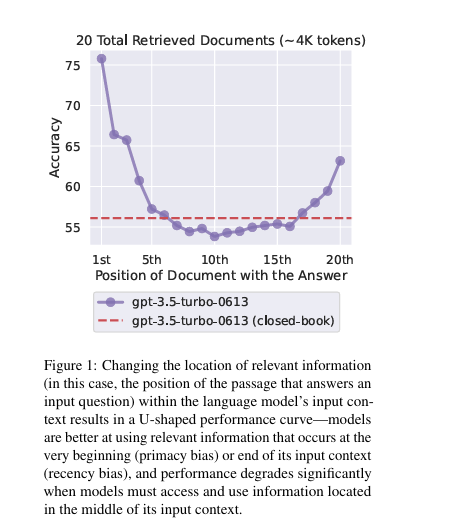

* Source Paper: [Lost in the Middle: How Language Models Use Long Contexts](https://arxiv.org/abs/2307.03172)

## How this works
* [source](https://medium.com/@juanc.olamendy/lost-in-the-middle-a-deep-dive-into-rag-and-langchains-solution-3eccfbe65f49)
* Instead of sticking to the traditional retrieval order, LangChain shuffles the deck.
  * This places the **most similar documents at the top**, the next set at the bottom, and the least similar ones right in the middle.

* The `LongContextReorder` automatically does this!
  * Create any retriever object.
  * Get the relevant documents using the `get_relevant_documents()` method of that retriever
  * Return documents in descending order of their similarity score.
  * Pass these documents to an instance of the `LongContextReorder()`
  * Get the re-ordered docs where the least relevant ones are at the middle

In [108]:
from langchain_community.document_transformers import LongContextReorder

In [109]:
## reordering in action
reorder = LongContextReorder()
reorder_docs = reorder.transform_documents(rerank_docs)
reorder_docs

['The pasta selection is a highlight of the menu, featuring classics like lasagna, ravioli, and',
 'possible, providing support and advice at every step.',
 "financial advisors are skilled in crafting investment strategies that align with clients' long-term",
 "planning, and estate planning, ensuring clients' financial futures are secure.",
 'from rich and creamy to light and zesty, are made with the freshest ingredients, bringing out the']

Summary
* We were able to see 3 advanced retrieval techniques here:

1. Query Expansion
2. Cross Encoder with Rerank
3. LongContextReorder

* The final technique gives us the documents in the correct order which can then be sent to the LLM for synthesis and generative outputs.
* These are just a few advanced RAG tricks and techniques to reduce information and context loss in RAG-LLM pipelines.